**Sentiment Analysis of IMDB Movie Reviews**

In [5]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import os
import warnings
warnings.filterwarnings('ignore')


**Import the training dataset**

In [6]:

imdb_data=pd.read_csv('IMDB Dataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


**Exploratery data analysis**

In [7]:

imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


**Sentiment count**

In [8]:

imdb_data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

We can see that the dataset is balanced.

**Spliting the training dataset**

In [9]:

train_reviews=imdb_data.review[:40000]
train_sentiments=imdb_data.sentiment[:40000]

test_reviews=imdb_data.review[40000:]
test_sentiments=imdb_data.sentiment[40000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91954\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Text normalization**

In [11]:

tokenizer=ToktokTokenizer()

stopword_list=nltk.corpus.stopwords.words('english')

**Removing html strips and noise text**

In [12]:

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)


def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

imdb_data['review']=imdb_data['review'].apply(denoise_text)

**Removing special characters**

In [13]:

def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

**Text stemming
**

In [14]:

def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

**Removing stopwords**

In [15]:

stop=set(stopwords.words('english'))
print(stop)


def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

{'the', 'i', 'doing', 'where', 'this', "don't", 'above', 'as', "shouldn't", 'are', "mightn't", 'other', 'mightn', 'y', 'ours', 'my', 'at', 've', "you'd", 'doesn', 'wouldn', 'against', 'further', 'while', 'about', 'no', 'won', "wouldn't", 'will', 'these', 'whom', 'myself', "hasn't", "doesn't", 'o', "couldn't", 'do', 'again', 'which', 'such', "haven't", 'isn', 'over', 'has', 'under', "didn't", 'be', 'there', 'we', "won't", 'but', 'shouldn', 'by', 'were', 'a', 'those', 'before', 'here', 'when', "it's", 'shan', 'haven', 'both', 're', 'through', 'weren', "you're", 'theirs', 'same', 'than', 'themselves', 'once', "aren't", 'ma', 'of', 'each', 'hasn', 'himself', 'they', 'any', 'you', 'then', 'she', "that'll", 'so', 'can', 'wasn', 'him', "you've", 't', 'her', 'if', 'off', "should've", 'and', 'after', 'having', 'yourself', 'more', 'their', 'your', 'between', 'from', 'yourselves', 'how', "shan't", 'because', 'few', 'have', 'ain', "hadn't", "weren't", 'hadn', 'hers', 'should', 'nor', 'did', 'for',

**Normalized train reviews**

In [16]:

norm_train_reviews=imdb_data.review[:40000]
norm_train_reviews[0]


'one review ha mention watch 1 oz episod youll hook right thi exactli happen meth first thing struck oz wa brutal unflinch scene violenc set right word go trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

**Normalized test reviews**

In [17]:

norm_test_reviews=imdb_data.review[40000:]
norm_test_reviews[45005]


'read review watch thi piec cinemat garbag took least 2 page find somebodi els didnt think thi appallingli unfunni montag wasnt acm humour 70 inde ani era thi isnt least funni set sketch comedi ive ever seen itll till come along half skit alreadi done infinit better act monti python woodi allen wa say nice piec anim last 90 second highlight thi film would still get close sum mindless drivelridden thi wast 75 minut semin comedi onli world semin realli doe mean semen scatolog humour onli world scat actual fece precursor joke onli mean thi handbook comedi tit bum odd beaver niceif pubesc boy least one hand free havent found playboy exist give break becaus wa earli 70 way sketch comedi go back least ten year prior onli way could even forgiv thi film even made wa gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 becaus wa lower scoreand

**Bags of words model **

It is used to convert text documents to numerical vectors or bag of words.

In [18]:

cv=CountVectorizer(min_df=1,max_df=1,binary=False,ngram_range=(1,3))

cv_train_reviews=cv.fit_transform(norm_train_reviews)

cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)


BOW_cv_train: (40000, 6209089)
BOW_cv_test: (10000, 6209089)


**Term Frequency-Inverse Document Frequency model (TFIDF)**

It is used to convert text documents to  matrix of  tfidf features.

In [22]:

tv=TfidfVectorizer(min_df=1,max_df=1,use_idf=True,ngram_range=(1,3))

tv_train_reviews=tv.fit_transform(norm_train_reviews)

tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6209089)
Tfidf_test: (10000, 6209089)


**Labeling the sentiment text**

In [23]:

lb=LabelBinarizer()

sentiment_data=lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

(50000, 1)


**Split the sentiment tdata**

In [24]:

train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


**Modelling the dataset**

**Multinomial Naive Bayes for bag of words and tfidf features**

In [25]:

mnb=MultinomialNB()

mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)

mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


In [26]:
%time mnb = MultinomialNB().fit(cv_train_reviews, train_sentiments)

CPU times: total: 438 ms
Wall time: 487 ms


**Model performance on test data**

In [27]:

mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)

mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


**Accuracy of the model**

In [28]:

mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)

mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.7474
mnb_tfidf_score : 0.7474


Print the Classification Reports

In [29]:
from sklearn.metrics import classification_report

report_bow = classification_report(test_sentiments, mnb_bow_predict, target_names=['Positive','Negative'])
print("Classification Report for Bag of Words: \n",report_bow)

report_tfidf = classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print("Classification Report for TFIDF Features:\n",report_tfidf)


Classification Report for Bag of Words: 
               precision    recall  f1-score   support

    Positive       0.74      0.77      0.75      4993
    Negative       0.76      0.73      0.74      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

Classification Report for TFIDF Features:
               precision    recall  f1-score   support

    Positive       0.74      0.77      0.75      4993
    Negative       0.76      0.73      0.74      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



**Plot the confusion matrix**

In [30]:

cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
print(cm_bow)

cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3641 1366]
 [1160 3833]]
[[3641 1366]
 [1160 3833]]


**Let us see positive and negative words by using WordCloud.**

**Word cloud for positive review words**

<function matplotlib.pyplot.show(close=None, block=None)>

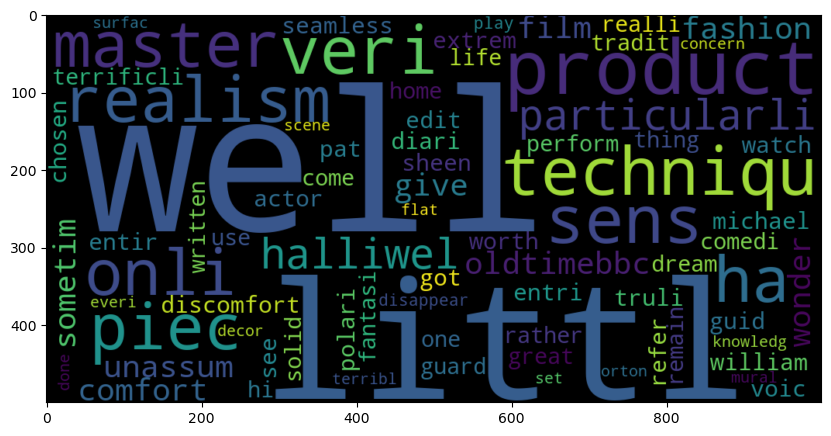

In [31]:

plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

**Word cloud for negative review words**

<function matplotlib.pyplot.show(close=None, block=None)>

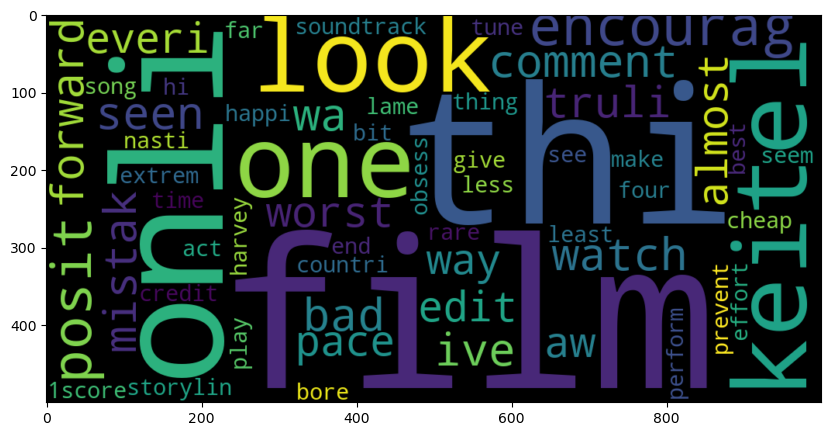

In [32]:

plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

SAVE THE MODEL IN AN .pkl file for future use

In [33]:
import joblib

In [34]:



model_directory = r'C:\Users\91954\Desktop\Python\Models'  
model_filename = 'sentiment_analysis.pkl'
model_path = f'{model_directory}\\{model_filename}'


joblib.dump(mnb_bow, model_path)


['C:\\Users\\91954\\Desktop\\Python\\Models\\sentiment_analysis.pkl']

In [35]:

joblib.dump(cv, 'C:\\Users\\91954\\Desktop\\Python\\Models\\count_vectorizer.pkl')


['C:\\Users\\91954\\Desktop\\Python\\Models\\count_vectorizer.pkl']